In [202]:
import pandas as pd
import subprocess
import math
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

In [203]:
DATA_DIR = "/home/nasm716/row_hammer/row_hammer_data/"
DATA_DIR = "/home/nasm716/row_hammer/row_hammer_data/"
temp_list=["m75","low","m15","15","25"]
pre_data_dict=dict()
for temp in temp_list:
    data=DATA_DIR+temp+"/threshold_data.txt"
    pre_data_dict[temp]=data
print(pre_data_dict)    
# ION_LIN_SP = HYNIX_LIB_DIR + "ion_lin.sp"
# ION_SAT_SP = HYNIX_LIB_DIR + "ion_sat.sp"
# U0_SP = HYNIX_LIB_DIR + "u0_extraction.sp"
# UEFF_SP = HYNIX_LIB_DIR + "ueff_extraction.sp" 
# VSAT_SP = HYNIX_LIB_DIR + "vsat_extraction.sp"
# ION_RATIO_SP=HYNIX_LIB_DIR + "ion_ratio.sp"`

{'low': '/home/nasm716/row_hammer/row_hammer_data/low/threshold_data.txt', '25': '/home/nasm716/row_hammer/row_hammer_data/25/threshold_data.txt', '15': '/home/nasm716/row_hammer/row_hammer_data/15/threshold_data.txt', 'm75': '/home/nasm716/row_hammer/row_hammer_data/m75/threshold_data.txt', 'm15': '/home/nasm716/row_hammer/row_hammer_data/m15/threshold_data.txt'}


In [204]:
def failure_bit(data):
    f = open(data, 'r')
    failure_bit=dict()
    addr_list=list()
    retention_time=0

    for line in f:
        
        line=line.split(" ")    
        if len(line)>1 and line[1]=="attack":
            if retention_time==0:
                retention_time=int(int(line[0],16)/1000)
            else:
                failure_bit[retention_time]=addr_list
                retention_time=int(int(line[0],16)/1000)
                addr_list=[]
        elif len(line)==3:
            bit_addr=int(line[0],16)*64+int(line[1],16)
            addr_list.append(bit_addr)
#     failure_bit[retention_time]=addr_list
#     count_bits(failure_bit)
    f.close()
    return failure_bit


In [205]:
def count_bits(failure_bit,temp):
    if(temp=="low"):
        temp=-25
    elif(temp=="m15"):
        temp=-15
    elif(temp=="m75"):
        temp=-75
    else:
        temp=int(temp)
    count_data=pd.DataFrame(columns=["th",temp])
    th_list=list(failure_bit.keys())
    th_list.sort()
    for th in th_list:
         count_data=count_data.append({"th":th,temp:len(failure_bit[th])},ignore_index=True)
         count_data['th'] = pd.to_numeric(count_data['th'])
         count_data[temp] = pd.to_numeric(count_data[temp])
    #count_data=count_data.T
    return count_data

In [206]:
def classify_failure_bits(failure_bit):
    classify_failure_bits=pd.DataFrame()
    time_list=list(failure_bit.keys())
    time_list.sort()
    idx=0
    past_key=0
    num_classify_data=0
    failed_cell=list()
    
    for retention_time in time_list:
#        print(retention_time ,":")
        idx=0
        unique=0
        non_repeat=0
        repeat=0
        num_failed_cell=len(failed_cell)
        for current_fail_addr in failure_bit[retention_time]:
            while(idx<len(failed_cell) and failed_cell[idx]<current_fail_addr):
                    idx=idx+1
            if(idx<len(failed_cell) and failed_cell[idx]==current_fail_addr):
                repeat=repeat+1
            else:
                unique=unique+1
                failed_cell.append(current_fail_addr)
        failed_cell.sort()
        non_repeat=len(failed_cell)-repeat-unique
        classify_failure_bits[retention_time]=[repeat,non_repeat,unique]
    
#         display(failed_cell)
#         print("repeat :", repeat)
#         print("non_repeat:", non_repeat) #non_repeat=total_cell-repeat-unique
#         print("unique:" ,unique)
    classify_failure_bits=classify_failure_bits.T
    classify_failure_bits=classify_failure_bits.rename(columns={0:'repeat',1:"non_repeat",2:"unique"});
    return classify_failure_bits 

In [207]:
def graph(data):
    data.plot.bar(title="Row-Hammer Threshold",x="th")
    plt.xlabel("RHth(K)")
    plt.ylabel("# of fliped_bit")

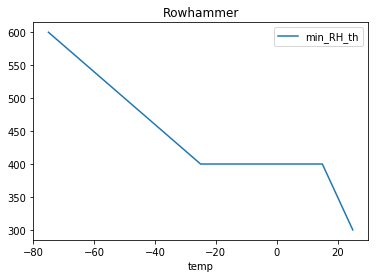

In [220]:
data=pd.DataFrame({"temp":[25,15,-15,-25,-75],"min_RH_th":[300,400,400,400,600]})
data.plot(kind='line',title="Rowhammer",x="temp",y="min_RH_th")


      th    -25     25     15   -75    -15
0    200    0.0    0.0    NaN   NaN    NaN
1    300    0.0    1.0    NaN   NaN    NaN
2    400    1.0    4.0    1.0   0.0    1.0
3    500   34.0   14.0    9.0   NaN    4.0
4    600    6.0   37.0   16.0   2.0    8.0
5    700   11.0   85.0   36.0   NaN   14.0
6    800   20.0  143.0   65.0   4.0   22.0
7    900   27.0  216.0  101.0   NaN   34.0
8   1000   41.0  328.0  135.0   6.0   51.0
9   1100   57.0  447.0  197.0   NaN   76.0
10  1200   85.0  650.0  277.0  11.0   99.0
11  1300  109.0  867.0  369.0   NaN  133.0
12  1400    NaN    NaN  473.0   NaN  184.0
13  1500    NaN    NaN    NaN   NaN  225.0


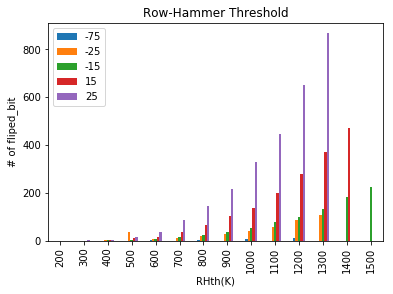

In [208]:
result_list=[]
partial_result=pd.DataFrame()
result=pd.DataFrame()
for i,(key, val) in enumerate(pre_data_dict.items()):
    partial_result=(count_bits(failure_bit(val),key))
    result_list.append(partial_result)
    if(i==0):
        result=partial_result
    else:
        result= pd.merge(result, partial_result, on='th',how='outer')
print(result)
result=result[[result.columns[0]] + sorted([col for col in result if col != result.columns[0]])]
graph(result)
# data1=count_bits(failure_bit(DATA1))
# data2=count_bits(failure_bit(DATA2))
# data=pd.DataFrame
# data=pd.concat([data1,data2],axis=1)
# data=data.dropna()
# data.columns=["260K","300K"]
# graph(data)

In [209]:
f = open(DATA2, 'r')
failure_bit=dict()
addr_list=list()
retention_time=0

for line in f:
    line=line.split(" ")
    if len(line)==1: #end of file    
        if(line[0]=="end"):
            failure_bit[retention_time]=addr_list
            break
        else:
            continue
    elif line[1]==":":
        if retention_time==0:
            retention_time=int(float(line[0]))
        else:
            failure_bit[retention_time]=addr_list
            retention_time=int(float(line[0]))
            addr_list=[]
    else:
#         print(line[0])
        bit_addr=int(float(line[0]))*64+int(float(line[1]))
        addr_list.append(bit_addr)
#count_bits(failure_bit)
failure_bit2=failure_bit
classify_data2=classify_failure_bits(failure_bit)
classify_data.plot
display(failure_bit)
f.close()

NameError: name 'DATA2' is not defined

In [ ]:
def compare_failure_bits(failure_bit1,failure_bit2):
    classify_failure_bits=pd.DataFrame()
    time_list=list(failure_bit.keys())
    time_list.sort()
    idx=0
    past_key=0
    num_classify_data=0
    failed_cell1=list()
    
    for retention_time in time_list:
#        print(retention_time ,":")
        idx=0
        unique=0
        non_repeat=0
        repeat=0
        num_failed_cell=len(failed_cell)
        for current_fail_addr in failure_bit1[retention_time]:
            while(idx<len(failed_cell1) and failed_cell1[idx]<current_fail_addr):
                    idx=idx+1
            if(idx<len(failed_cell1) and failed_cell1[idx]==current_fail_addr):
                repeat=repeat+1
            else:
                unique=unique+1
                failed_cell1.append(current_fail_addr)
        failed_cell1.sort()
        non_repeat=len(failed_cell)-repeat-unique
        
        idx=0
        unique=0
        non_repeat=0
        repeat=0
        num_failed_cell=len(failed_cell)
        for current_fail_addr in failure_bit2[retention_time]:
            while(idx<len(failed_cell2) and failed_cell2[idx]<current_fail_addr):
                    idx=idx+1
            if(idx<len(failed_cell2) and failed_cell2[idx]==current_fail_addr):
                repeat=repeat+1
            else:
                unique=unique+1
                failed_cell2.append(current_fail_addr)
        failed_cell2.sort()
        non_repeat=len(failed_cell2)-repeat-unique
        
        classify_failure_bits[retention_time]=[repeat,non_repeat,unique]
    
#         display(failed_cell)
#         print("repeat :", repeat)
#         print("non_repeat:", non_repeat) #non_repeat=total_cell-repeat-unique
#         print("unique:" ,unique)
    classify_failure_bits=classify_failure_bits.T
    classify_failure_bits=classify_failure_bits.rename(columns={0:'repeat',1:"non_repeat",2:"unique"});
    return classify_failure_bits 

In [ ]:
compare_failure_bits(failure_bit1,failure_bit2)